In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import h5py
import numpy as np
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score as roc_auc_score
import matplotlib as mpl
import sys
import os
from pathlib import Path

from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score as roc_auc_score
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from util import *

In [28]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

$
\begin{aligned}
& \frac{1}{T}\sum_{t, l} w_{t,l} A(c|\alpha_{t,l}) B_1(x_1|\beta_{t,l}) B_2(x_2|\gamma_{t,l}) \\
\end{aligned}
$

In [29]:
def process_data(file, y_labels, x_labels, test=False):
    # Read data
    data = h5py.File(file, "r")
    df = pd.DataFrame(columns = x_labels)

    for i in range(len(x_labels)):
        df[x_labels[i]] = np.array(data["data"][:, i]).flatten()
   
    if ("x1" in x_labels):
        df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    elif ("r_x" in x_labels):
        df = polar_to_cartesian_df(df, "x1", "x2", "r_x", "a_x")

    #df["Confidence"] = data["confidence"]
    for i in range(len(y_labels)):
        df[f"Std_samples_{y_labels[i]}"] = np.std(np.array(data["samples"][:, :, i]), axis=-1)
    
    # Get truth label values (annoying because text is not read as text, should fix)
    # Is fixed, just update
    if (test == False):
        df["class"] = data["truth"]
        df["Truth_label"] = y_labels[0]
        blue = 1.0
        df_copy = df.copy()
        mask = df_copy["class"] == blue
        df.loc[mask, "Truth_label"] = y_labels[1]
    
    # Get estimated probabilities
    for i in range(len(y_labels)):
        df[y_labels[i]] = data["probabilities"][:,i]
        df[f"Est_prob_{y_labels[i]}"] = data["probabilities"][:,i]

    # Get 25-75% error bars
    for i in range(len(y_labels)):
        df[f"quantile25_{y_labels[i]}"] = data["quantiles"][:, 1, i]
        df[f"quantile75_{y_labels[i]}"] = data["quantiles"][:, 2, i]
        df[f"Error_{y_labels[i]}"] = (df[f"quantile75_{y_labels[i]}"] - df[f"quantile25_{y_labels[i]}"])/2

    # Could be some NaNs
    len_nan = len(df[df.isnull().any(axis=1)])
    if len_nan > 0:
        print(f"Dropping {len_nan} rows of NaNs")
        df = df.dropna()

    # Get inferred color
    df["Inferred_color"] = df[[y_labels[0], y_labels[1]]].idxmax(axis=1)
    df["Inferred_class"] = 0 # red
    df_copy = df.copy()
    mask = df_copy["Inferred_color"] == "blue"
    df.loc[mask, "Inferred_class"] = 1

    
    return df

In [30]:
# Custom plot function
def plot_distributions(df):

    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8), layout="constrained")

    # Plot 2D data points
    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.1, ax=axs[0][0])
    df_blue = df[df["color"] == "blue"]
    sn.scatterplot(df_blue, x="x1", y = "x2", c="blue", alpha=0.1, ax=axs[1][0])
    axs[0][0].set_xlim(min(df["x1"]), max(df["x1"]))
    axs[0][0].set_ylim(min(df["x2"]), max(df["x2"]))
    axs[1][0].set_xlim(min(df["x1"]), max(df["x1"]))
    axs[1][0].set_ylim(min(df["x2"]), max(df["x2"]))
    
    # Plot angular distribution
    sn.histplot(df_red, x="a_x", color="red", ax=axs[0][1])
    sn.histplot(df_blue, x="a_x", color="blue", ax=axs[1][1])
    axs[0][2].set_xlabel(r"$\theta_x$")
    axs[1][2].set_xlabel(r"$\theta_x$")

    # Plot radial distribution
    sn.histplot(df_red, x="r_x", color="red", ax=axs[0][2])
    sn.histplot(df_blue, x="r_x", color="blue", ax=axs[1][2])
    axs[0][2].set_xlabel(r"$|\vec{x}|$")
    axs[1][2].set_xlabel(r"$|\vec{x}|$")
    axs[0][2].set_xlim(0, 25)
    axs[1][2].set_xlim(0, 25)

    # Ticks
    for ax in axs.flatten():
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()

    return fig, ax

### Setup and constants

In [31]:
# Setup

#MCMC constants
n_samples = 1200
#n_data = [250, 5000]

#n_data = [25, 50, 250, 500, 1000, 2000, 3000, 5000, 10000]
n_data = [250, 1000, 2000, 3000, 5000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25
n_chains = 10
n_plots = len(n_data)

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Data labels
y_labels = ["red", "blue"]
if polar:
    x_labels = ["r_x", "a_x"]
else:
    x_labels = ["x1", "x2"]

# Read files
folderpath = "inference"
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
testfile = f"test_n_10000_{tag}"
#testfile = f"val_n_5000_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nr1MC_4000"
truthfile_test = "analytical_solution_test_n_10000_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5_nr1MC_8000"
gridfile = f"x1_x2_grid"

if polar:
    analysis_folders = [f"{trainfile}/nsamples-{n_samples}_nchains-{n_chains}_ndata-{n_data[i]}_POLAR" for i in range(n_plots)]
else:
    analysis_folders = [f"{trainfile}/nsamples-{n_samples}_nchains-{n_chains}_ndata-{n_data[i]}" for i in range(n_plots)]
#valfiles = [f"{folderpath}/{folder}/{valfile}_inferred.h5" for folder in analysis_folders]
testfiles = [f"{folderpath}/{folder}/{testfile}_inferred.h5" for folder in analysis_folders]
gridfiles = [f"{folderpath}/{folder}/{gridfile}_inferred.h5" for folder in analysis_folders]

train_data = pd.read_csv(f"../data/{trainfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")
truth_data = truth_data[truth_data["r_x"] > R1_min-R2] # Remove undefined area
truth_test_data = pd.read_csv(f"../analytical/results/{truthfile_test}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")

grid_dfs = [process_data(file, y_labels, x_labels, test=True) for file in gridfiles]
test_dfs = [process_data(file, y_labels, x_labels, test=False) for file in testfiles]

for i in range(len(n_data)):
    if (not os.path.isdir(f"predictions/{trainfile}") ):
        os.mkdir(f"predictions/{trainfile}")
    test_dfs[i].to_csv(f"predictions/{trainfile}/{testfile}_predicted_MM_nsamples{n_samples}_nchains{n_chains}_ndata-{n_data[i]}.csv")
    grid_dfs[i].to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_MM_nsamples{n_samples}_nchains{n_chains}_ndata-{n_data[i]}.csv")

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]


In [32]:
test_dfs[0]

x1         x2        r_x       a_x  Std_samples_red  \
0      4.637181  11.350187  12.260921  1.182936         0.130220   
1     10.042744  10.382106  14.444543  0.802012         0.149312   
2     -5.605532  11.920284  13.172515  2.010363         0.151008   
3     -1.477669 -14.679668  14.753853  4.612066         0.137805   
4     -9.945727   8.379890  13.005386  2.441433         0.140830   
...         ...        ...        ...       ...              ...   
9995   0.596807   9.253463   9.272689  1.506390         0.111394   
9996  -6.404741   6.863661   9.387787  2.321621         0.126545   
9997 -11.277142   2.093363  11.469791  2.958053         0.108832   
9998   8.927445  11.836816  14.825974  0.924606         0.150940   
9999  -3.594322  -8.356490   9.096707  4.306187         0.127530   

      Std_samples_blue  class Truth_label       red  Est_prob_red      blue  \
0             0.130220    0.0         red  0.497705      0.497705  0.502295   
1             0.149312    0.0         red  0.533852      0.533852  0.466148   
2             0.151008    1.0        blue  0.521152      0.521152  0.478848   
3             0.137805    1.0        blue  0.682095      0.682095  0.317905   
4             0.140830    1.0        blue  0.528584      0.528584  0.471416   
...                ...    ...         ...       ...           ...       ...   
9995          0.111394    0.0         red  0.414841      0.414841  0.585159   
9996          0.126545    1.0        blue  0.321135      0.321135  0.678865   
9997          0.108832    1.0        blue  0.617839      0.617839  0.382161   
9998          0.150940    0.0         red  0.560116      0.560116  0.439884   
9999          0.127530    1.0        blue  0.405806      0.405806  0.594194   

      Est_prob_blue  quantile25_red  quantile75_red  Error_red  \
0          0.502295        0.407693        0.579382   0.085845   
1          0.466148        0.426449        0.643340   0.108445   
2          0.478848        0.415952        0.634853   0.109450   
3          0.317905        0.592772        0.785962   0.096595   
4          0.471416        0.432053        0.628740   0.098344   
...             ...             ...             ...        ...   
9995       0.585159        0.334596        0.487103   0.076253   
9996       0.678865        0.226107        0.408999   0.091446   
9997       0.382161        0.541415        0.697061   0.077823   
9998       0.439884        0.463378        0.665916   0.101269   
9999       0.594194        0.309983        0.491849   0.090933   

      quantile25_blue  quantile75_blue  Error_blue Inferred_color  \
0            0.420618         0.592307    0.085845           blue   
1            0.356660         0.573551    0.108445            red   
2            0.365147         0.584048    0.109450            red   
3            0.214038         0.407228    0.096595            red   
4            0.371260         0.567947    0.098344            red   
...               ...              ...         ...            ...   
9995         0.512897         0.665404    0.076253           blue   
9996         0.591001         0.773893    0.091446           blue   
9997         0.302939         0.458585    0.077823            red   
9998         0.334084         0.536622    0.101269            red   
9999         0.508151         0.690017    0.090933           blue   

      Inferred_class  
0                  1  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
9995               1  
9996               1  
9997               0  
9998               0  
9999               1  

[10000 rows x 20 columns]

### Plot training data and distributions

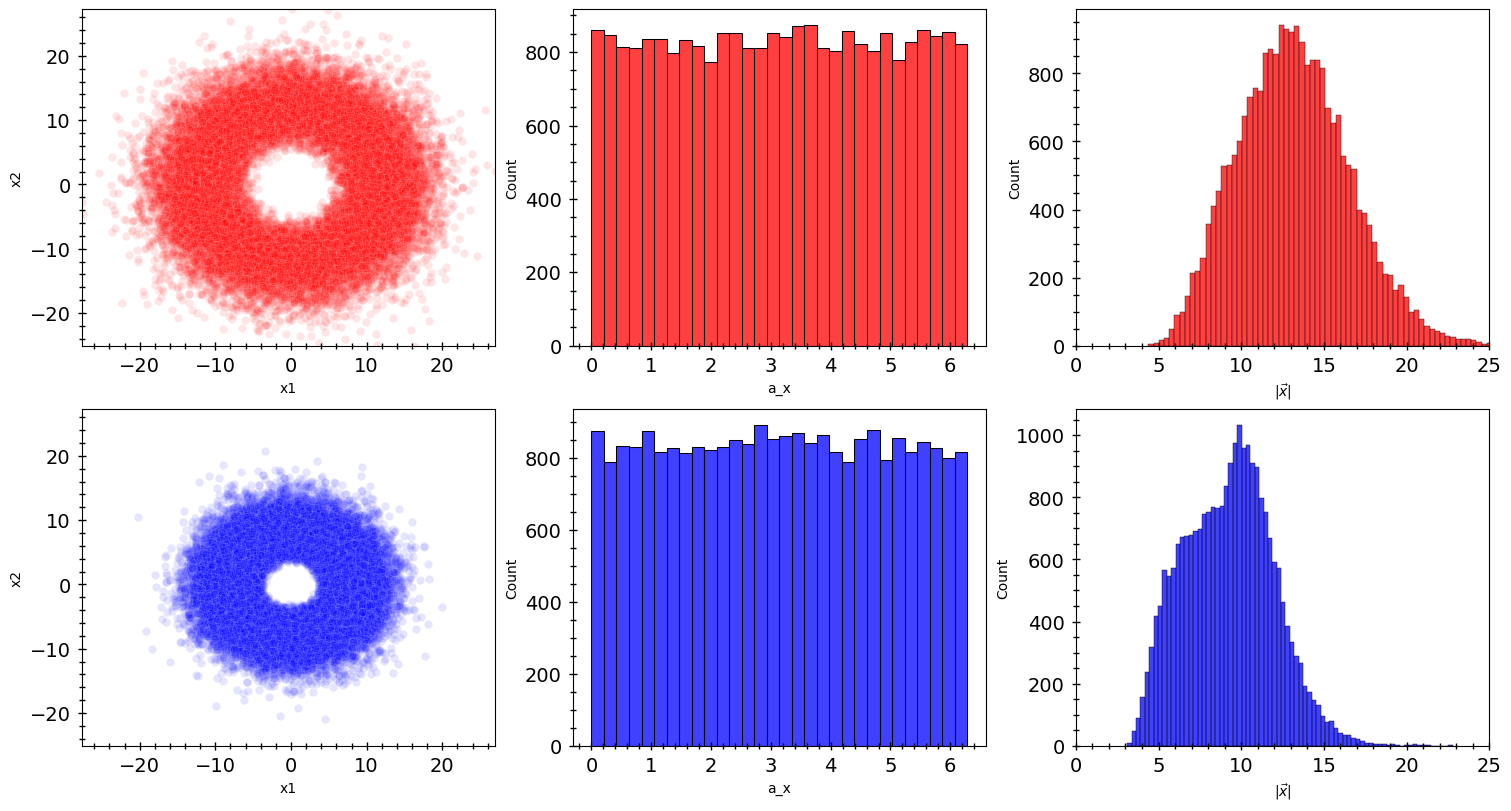

In [33]:
fig, ax = plot_distributions(train_data)

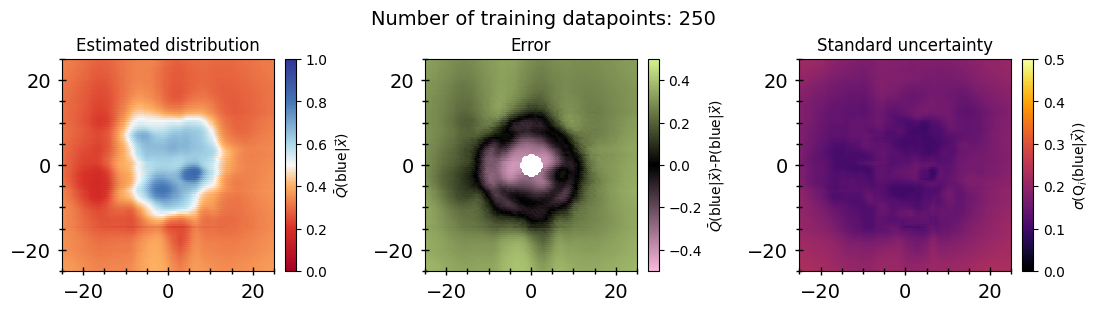

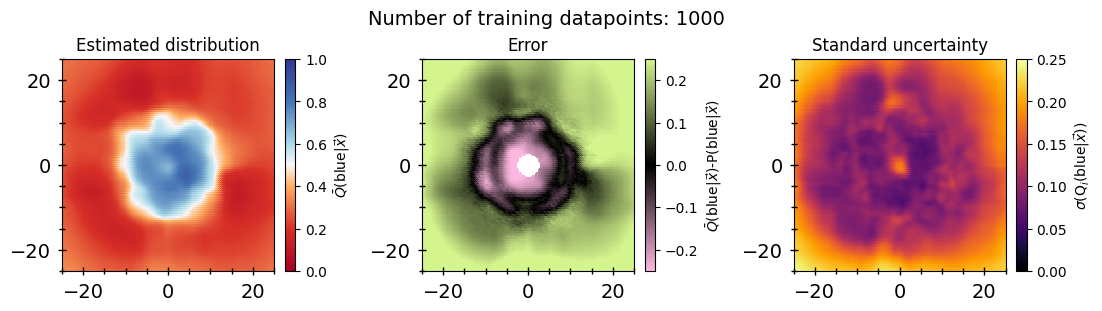

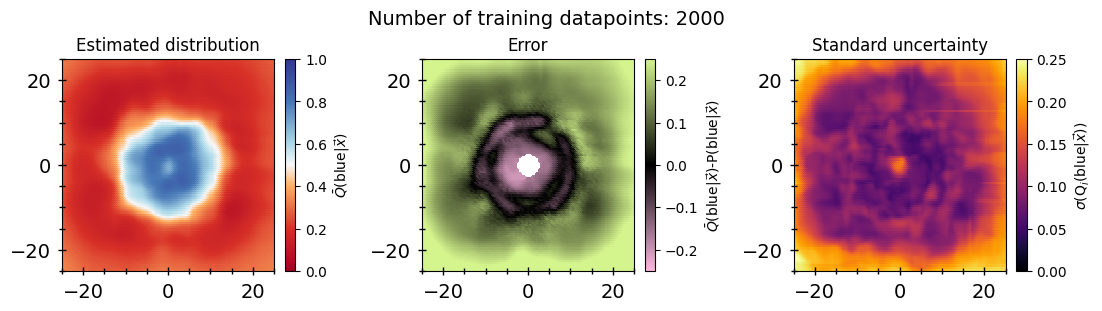

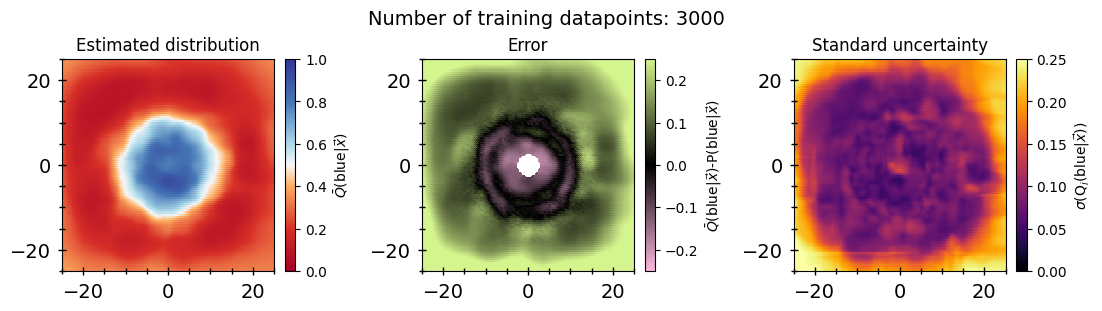

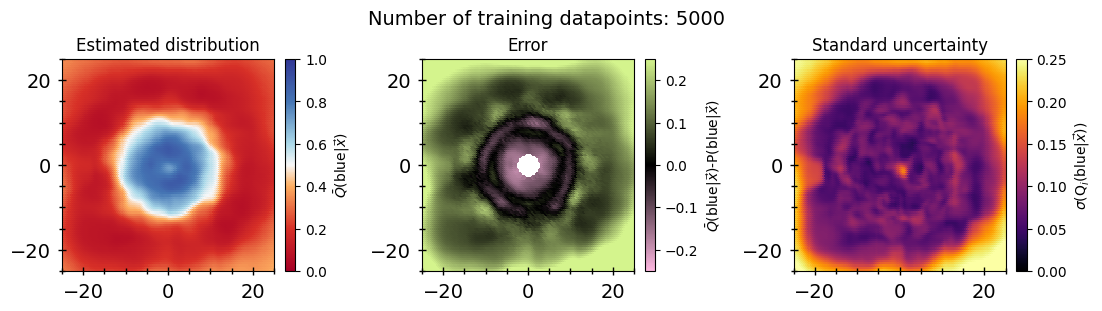

In [34]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")
    axs[0] = plot_results(grid_dfs[i], "Est_prob_blue", axs[0], "Estimated distribution", grid=True)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), fraction=0.050, pad=0.04, 
                 label=r"$\bar{Q}$(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_dfs[i], truth_data, "Est_prob_blue", "P_blue_given_x", axs[1], r"Error", max_val = max_err_val[i])
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), fraction=0.050, pad=0.04, 
                 label=r"$\bar{Q}$(blue|$\vec{x}$)-P(blue|$\vec{x}$)", ax=axs[1])

    axs[2] = plot_std(grid_dfs[i], "Std_samples_blue", axs[2], "Standard uncertainty", grid=True, max_val = max_err_val[i])
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"), fraction=0.050, pad=0.04, 
                 label=r"$\sigma$(Q$_i$(blue|$\vec{x}$))", ax=axs[2])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)
    #fig.savefig(f"../fig/mixture_model_ntrain_{n_data[i]}.pdf", format="pdf", bbox_inches='tight', dpi=350)


### Results from inference

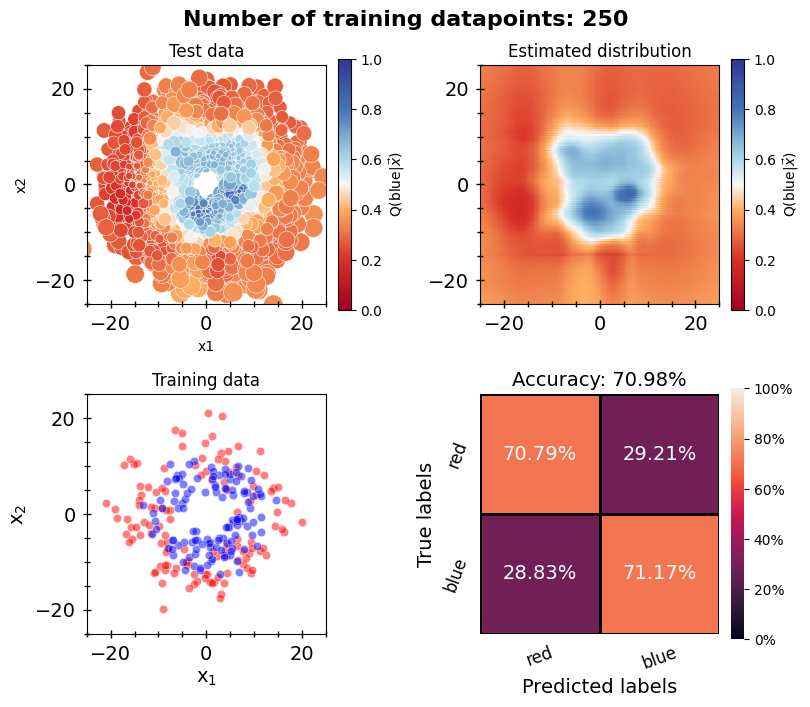

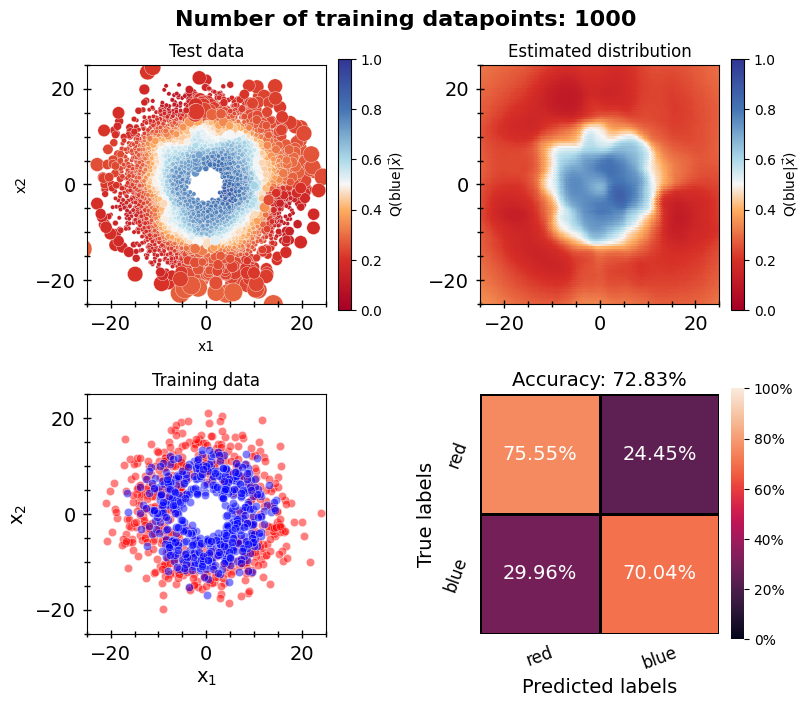

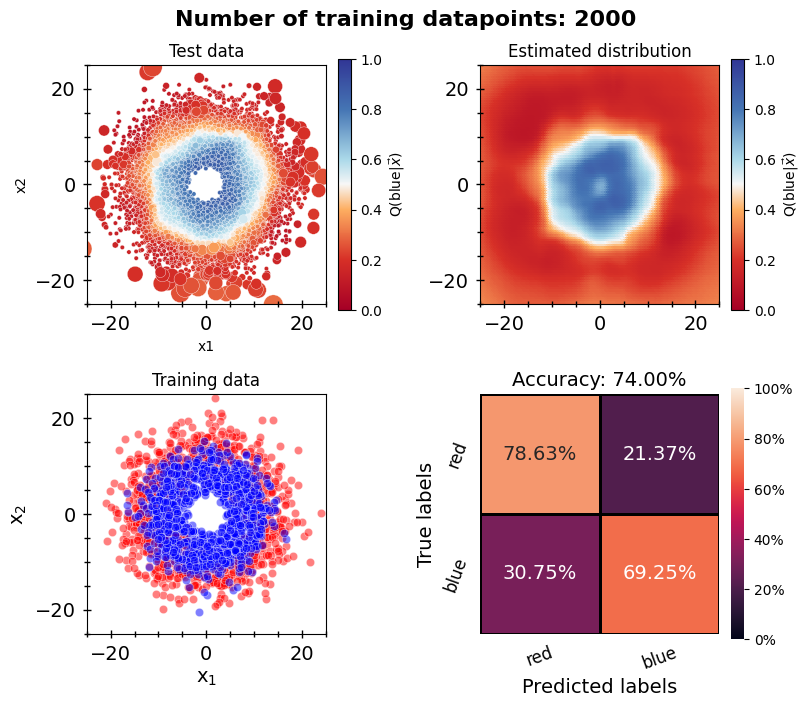

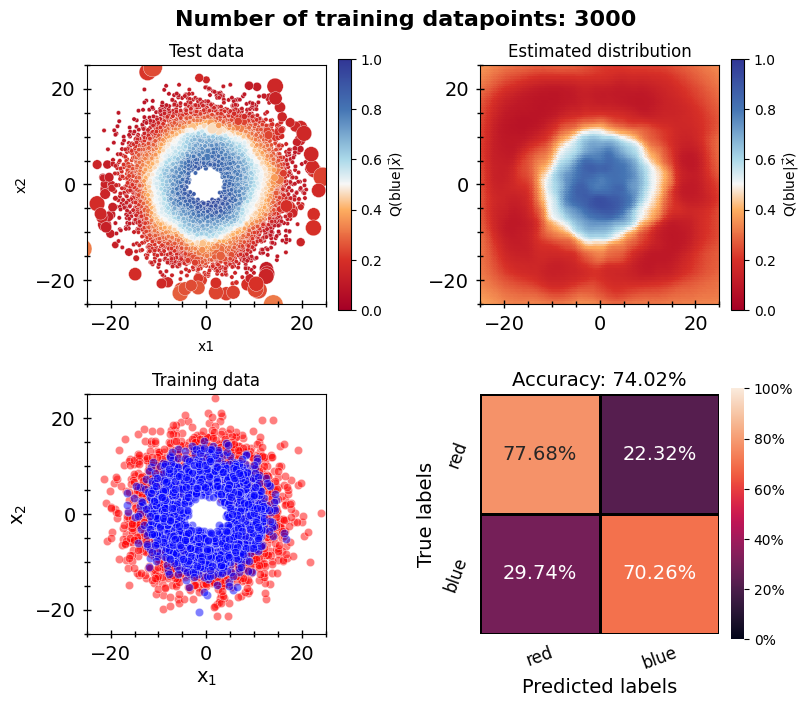

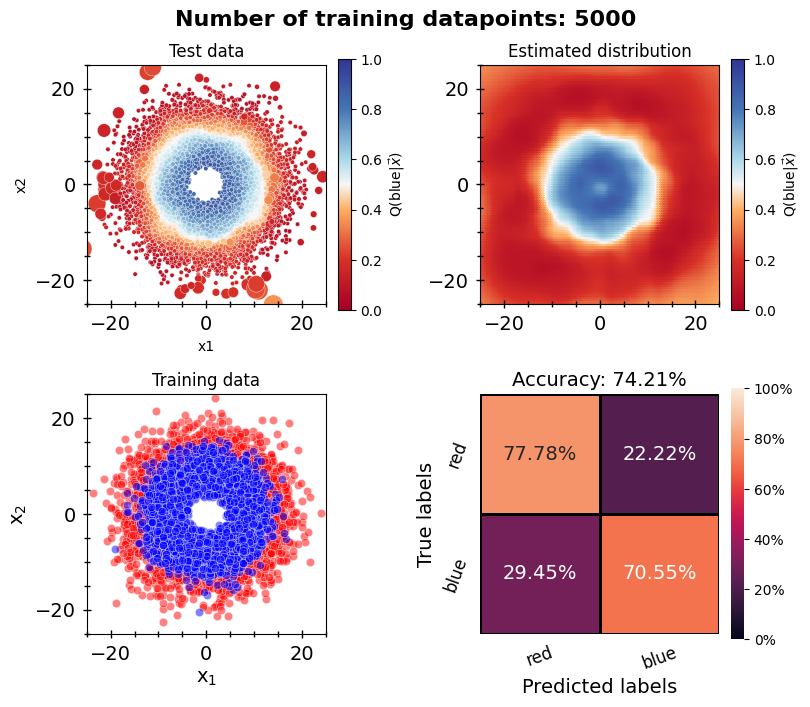

In [35]:

# Plot results

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,7), layout="constrained")
    
    #plot data
    axs[0][0] = plot_results(test_dfs[i], "Est_prob_blue", axs[0][0], "Test data", error_key="Std_samples_blue")
    axs[0][1] = plot_results(grid_dfs[i], "Est_prob_blue", axs[0][1], "Estimated distribution", grid=True)
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")
    axs[1][1] = plot_conf_matrix(test_dfs[i], "Truth_label", "Inferred_color", ["red", "blue"], axs[1][1])
    
    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")
    #plt.savefig(f"../../fig/results/inferno/{testfile}_{trainfile}_n_{n_data[i]}")

#plt.show()
    

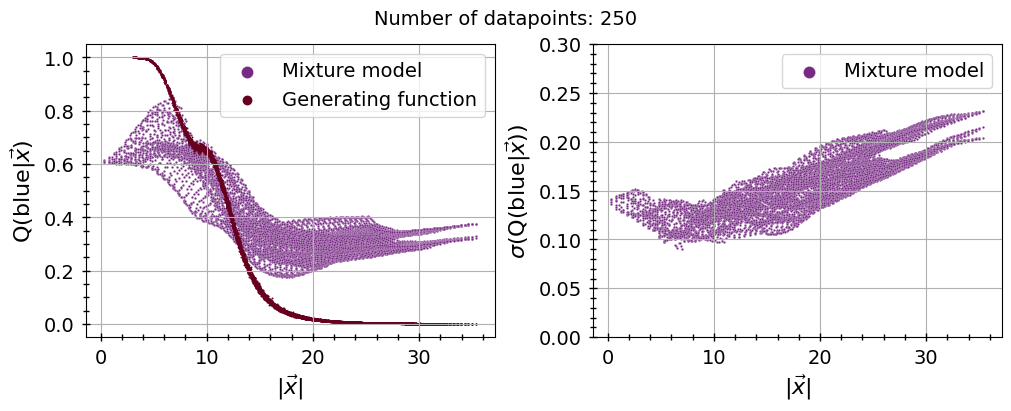

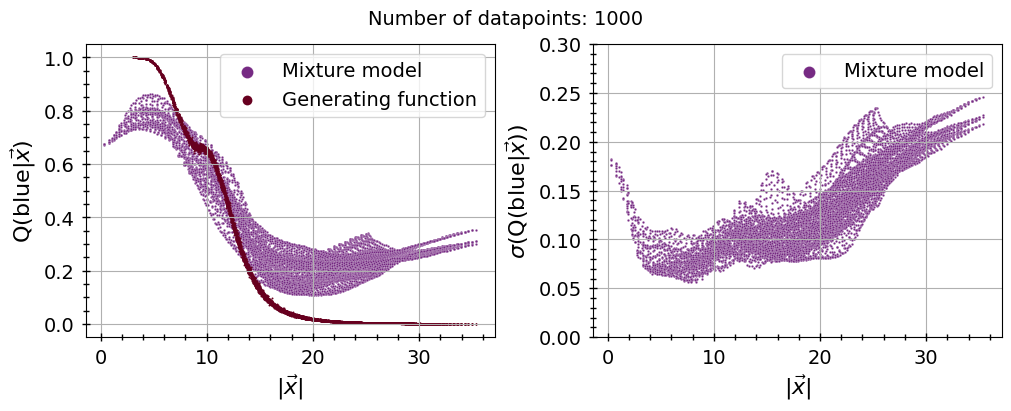

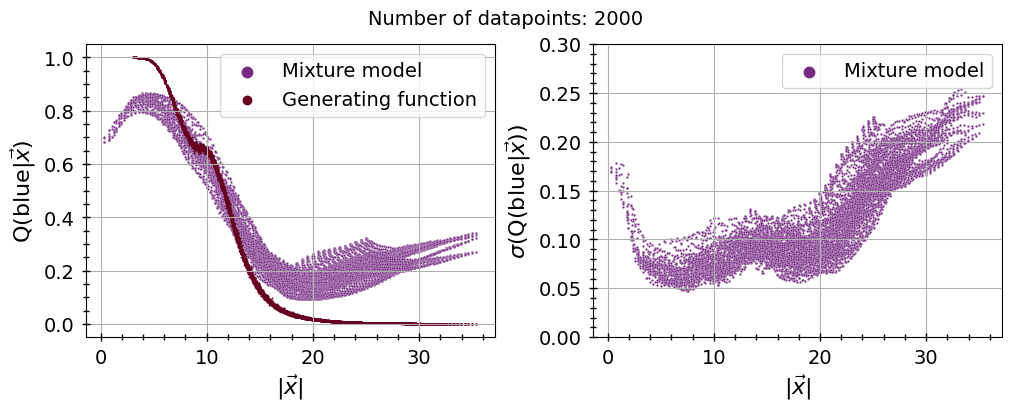

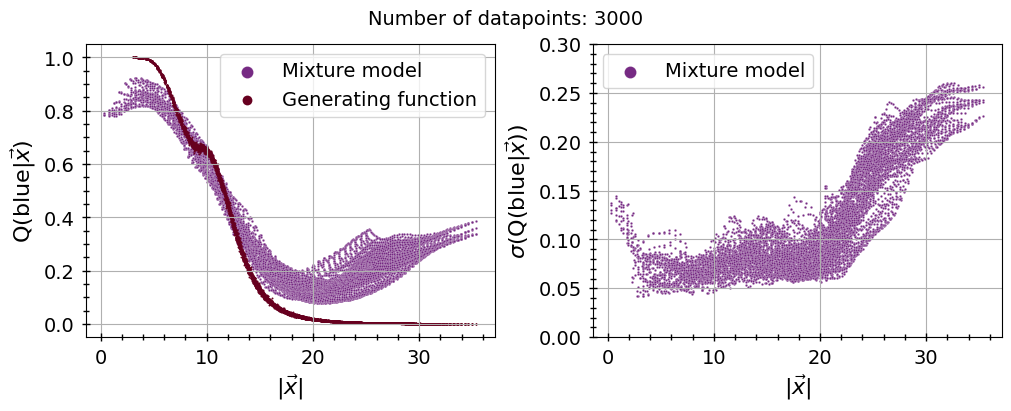

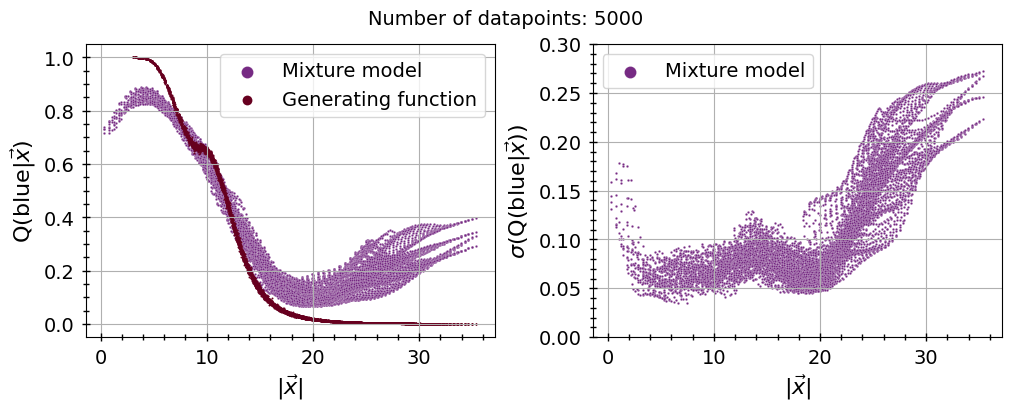

In [36]:
for i in range(n_plots):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_dfs[i], x="r_x", y="Est_prob_blue", s=3, ax = axs[0], label="Mixture model", color="#762a83")
    #sn.lineplot(truth_data, x="r_x", y="P_blue_given_x", linewidth=2, ax = axs[0], label="Generating function", color="#67001f")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[0], label="Generating function", color="#67001f", linewidth=0)
    axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_dfs[i], x="r_x", y="Std_samples_blue", s=3, ax = axs[1], label="Mixture model", color="#762a83")
    axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
    axs[1].set_ylim(0, 0.3)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_data[i]}", fontsize=14)


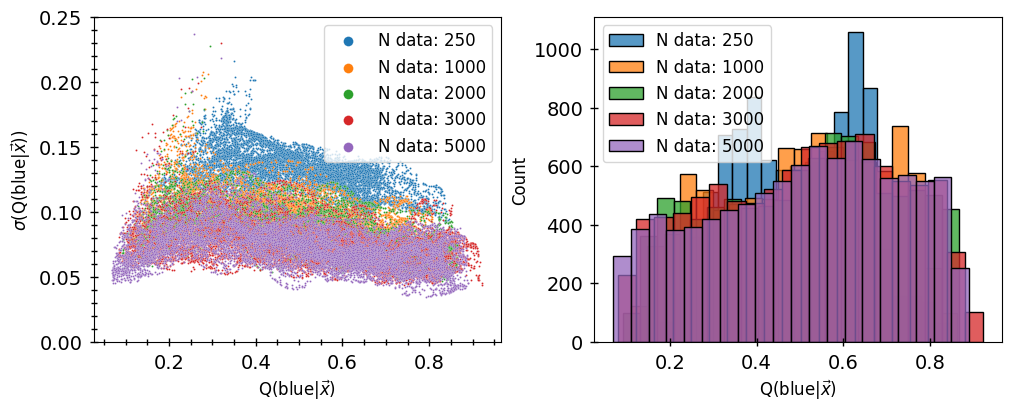

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(test_dfs[i], x="Est_prob_blue", y="Std_samples_blue", s=2, label=f"N data: {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5, fontsize=12)
    axs[0].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_ylim(0, 0.25)
    sn.histplot(test_dfs[i], x="Est_prob_blue", label=f"N data: {n_data[i]}", ax = axs[1], edgecolor="black", linewidth=1, bins=20)
    axs[1].legend(markerscale=5, fontsize=12)
    axs[1].set_ylabel("Count", fontsize=12)
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)

    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    #fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

In [38]:
scores = calculate_metrics(test_dfs, grid_dfs, n_data, truth_data, truth_test_data, 
                           "Inferred_class", "Est_prob_blue", "Std_samples_blue")
print(scores)

   N data     ACC    ROCAUC   WD test   WD grid    Avg UE    Std UE  \
0     250  0.7098  0.780900  0.120713  0.242006  0.129431  0.016639   
1    1000  0.7283  0.806843  0.083239  0.173093  0.092994  0.017472   
2    2000  0.7400  0.814667  0.066400  0.151964  0.081868  0.016908   
3    3000  0.7402  0.818583  0.060042  0.142437  0.076081  0.015306   
4    5000  0.7421  0.819559  0.057357  0.129049  0.073121  0.015830   

   Mean KL-div test  Mean KL-div grid   LogLoss       ECE       MCE     RMSCE  
0          0.046075          0.188520  0.590666  0.093342  0.181479  0.105517  
1          0.028868          0.129785  0.552539  0.075704  0.146064  0.085651  
2          0.023271          0.112726  0.539224  0.064493  0.141503  0.075408  
3          0.020365          0.105744  0.531961  0.062394  0.118256  0.071809  
4          0.018681          0.093502  0.529170  0.058762  0.112477  0.068438  


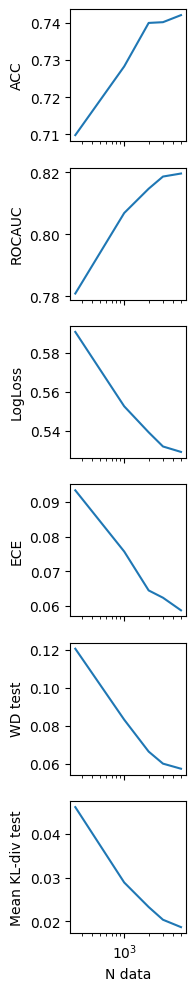

In [39]:
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(1.5, 12), sharex=True)
sn.lineplot(scores, x="N data", y="ACC", ax=axs[0])
sn.lineplot(scores, x="N data", y="ROCAUC", ax=axs[1])
sn.lineplot(scores, x="N data", y="LogLoss", ax=axs[2])
sn.lineplot(scores, x="N data", y="ECE", ax=axs[3])
sn.lineplot(scores, x="N data", y="WD test", ax=axs[4])
sn.lineplot(scores, x="N data", y="Mean KL-div test", ax=axs[5])
for ax in axs:
    ax.set_xscale("log")

### Calibration

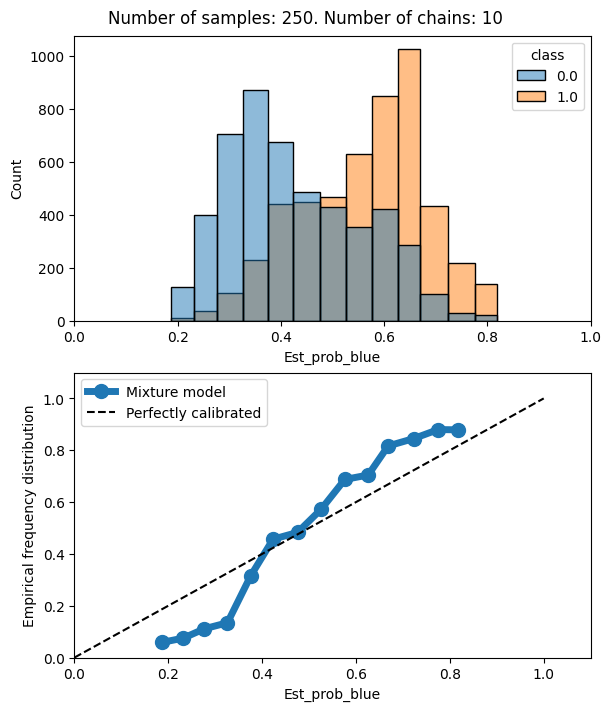

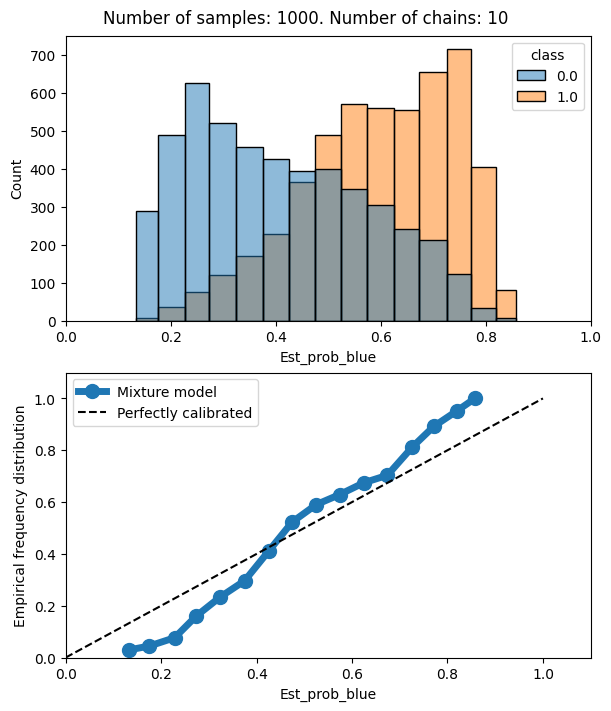

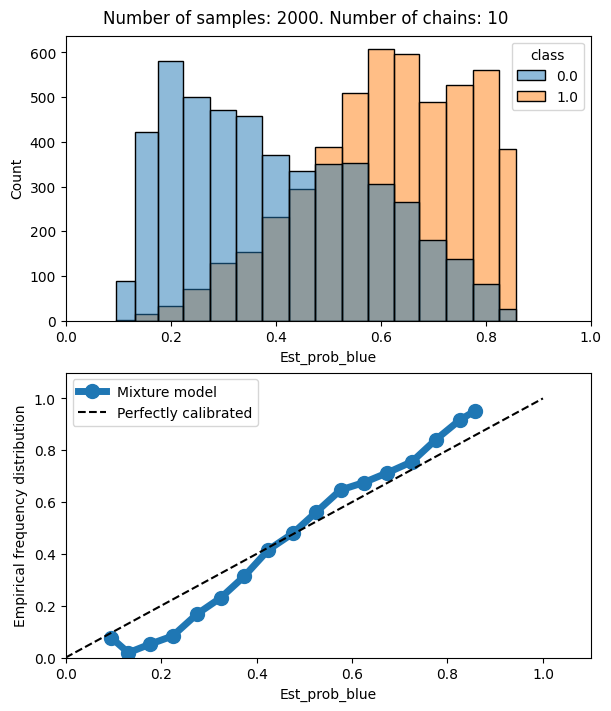

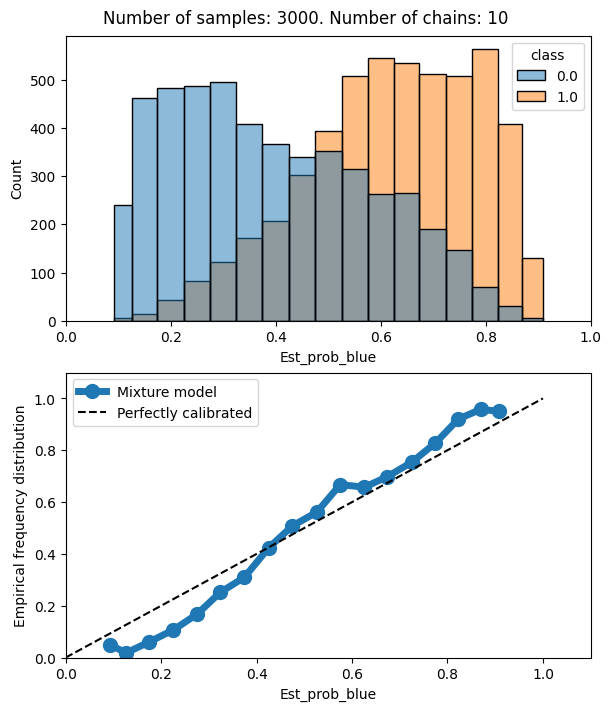

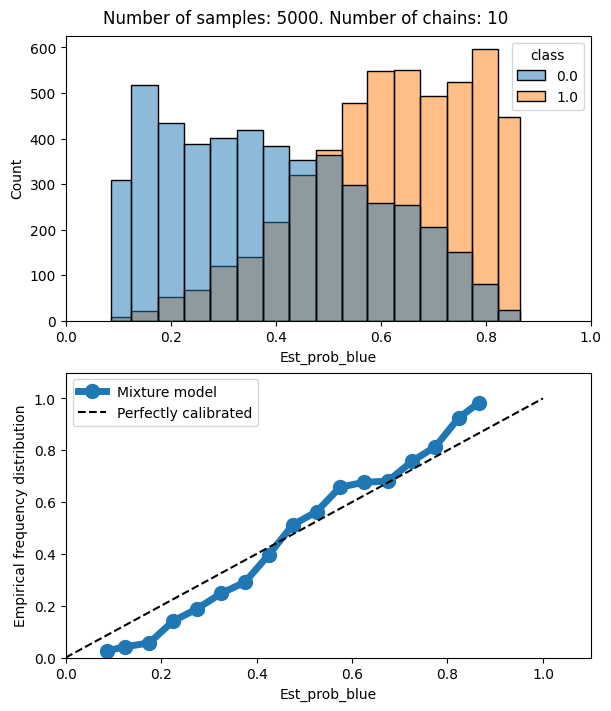

In [40]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

for i in range(n_plots):
    #Get confidence for red
    prob_cal, prob_pred = calibration_curve(test_dfs[i]["class"], test_dfs[i]["Est_prob_blue"], n_bins=20, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 7), layout="constrained")
    sn.histplot(test_dfs[i], x="Est_prob_blue", hue="class", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="Mixture model")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel("Est_prob_blue")
    ax[1].set_ylabel("Empirical frequency distribution")
    ax[1].legend()
    fig.suptitle(f"Number of samples: {n_data[i]}. Number of chains: {n_chains}")